Minimum terms required for each order to reach the target error for target_func1: {0: 49, 1: 49, 2: 49, 3: 49, 18: 49}


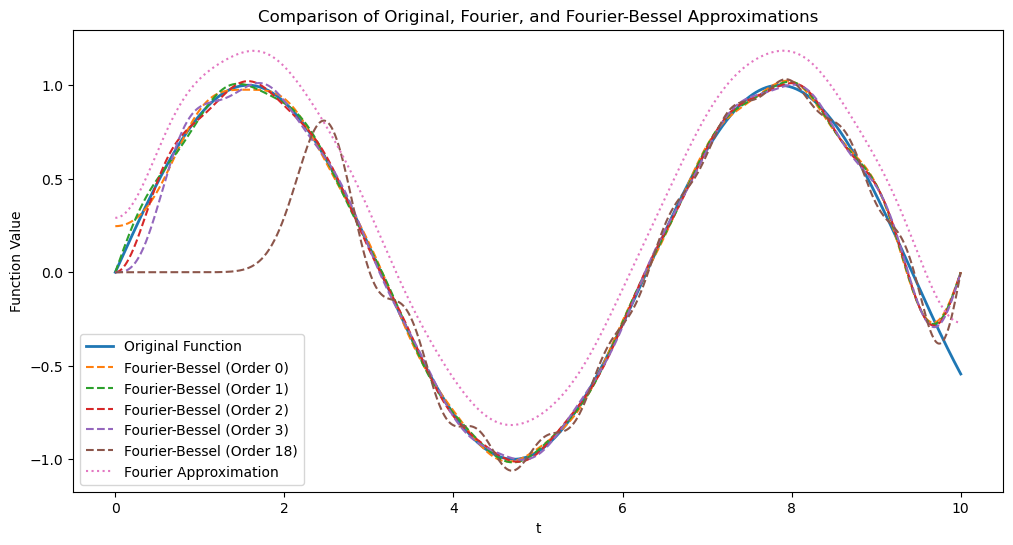

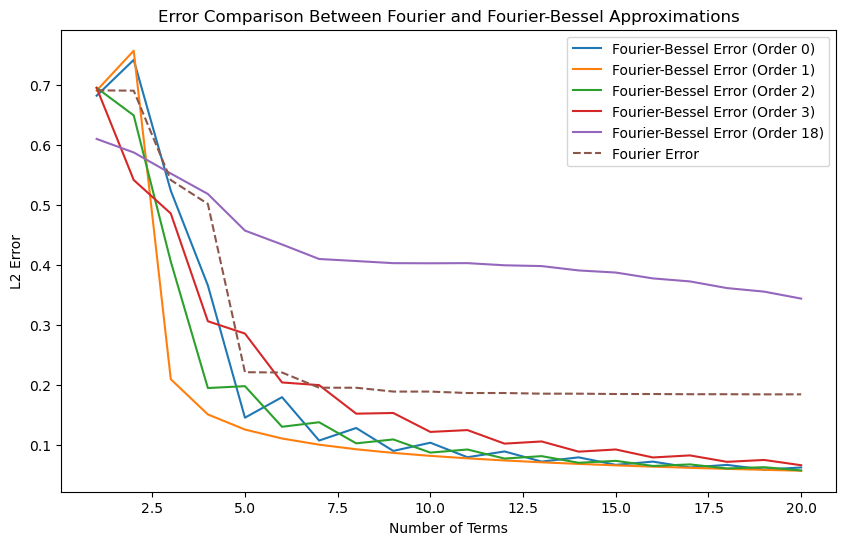

Minimum terms required for each order to reach the target error for target_func2: {0: 49, 1: 49, 2: 49, 3: 49, 18: 49}


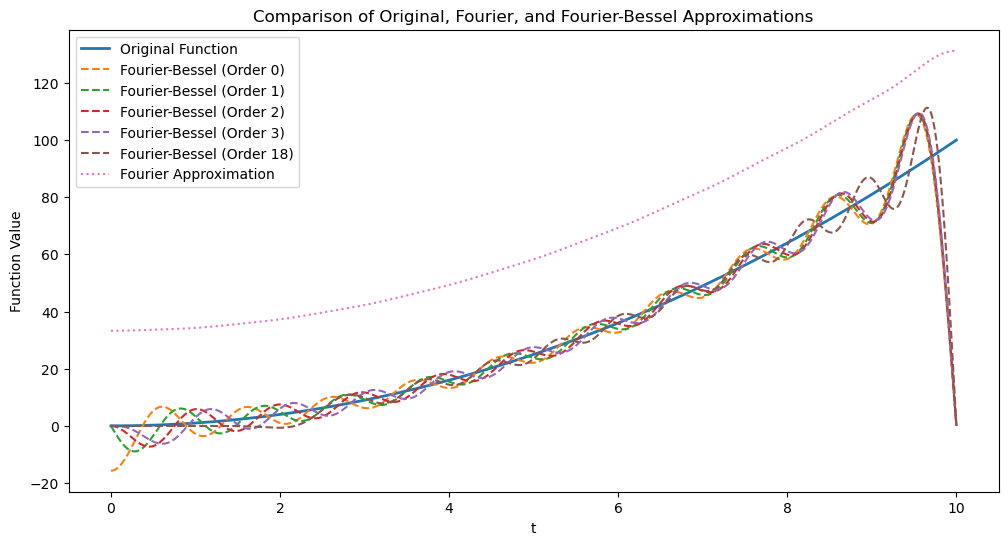

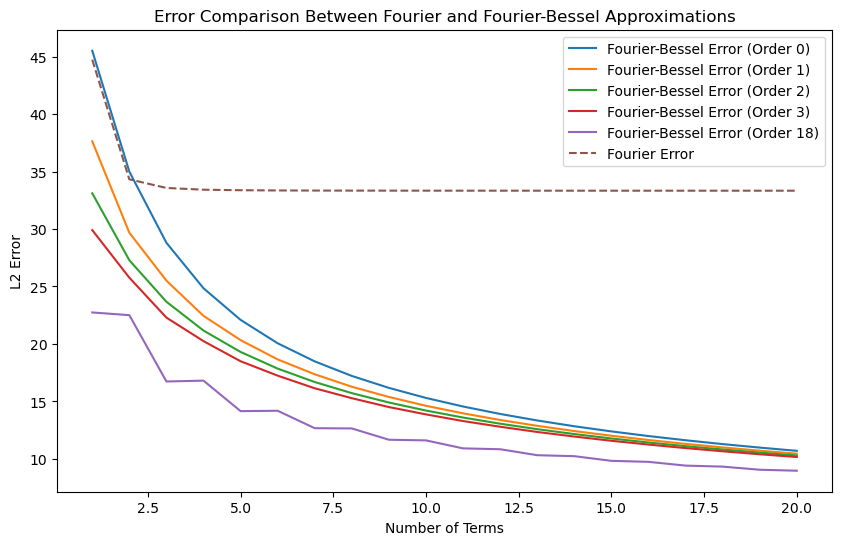

Minimum terms required for each order to reach the target error for target_func3: {0: 49, 1: 49, 2: 49, 3: 49, 18: 49}


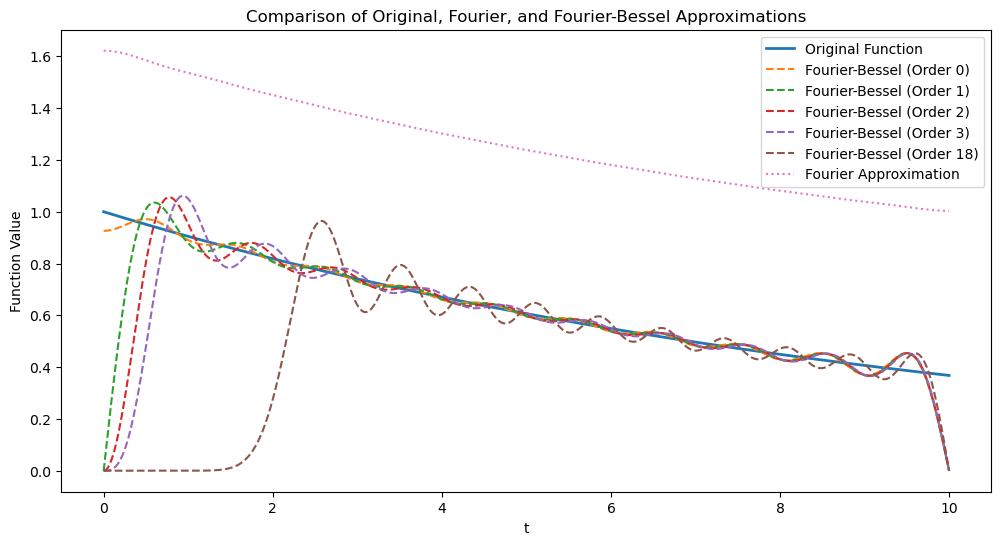

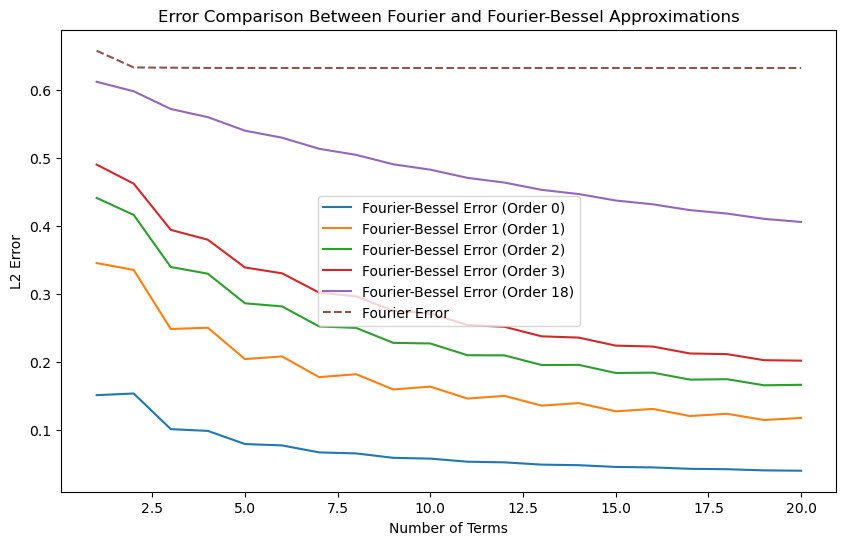

Minimum terms required for each order to reach the target error for unit_step: {0: 49, 1: 49, 2: 49, 3: 49, 18: 49}


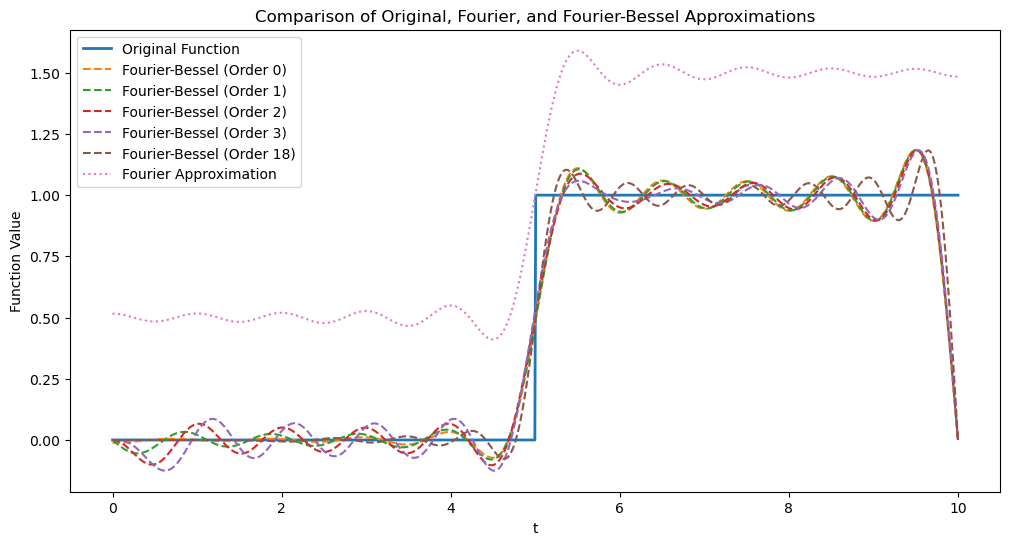

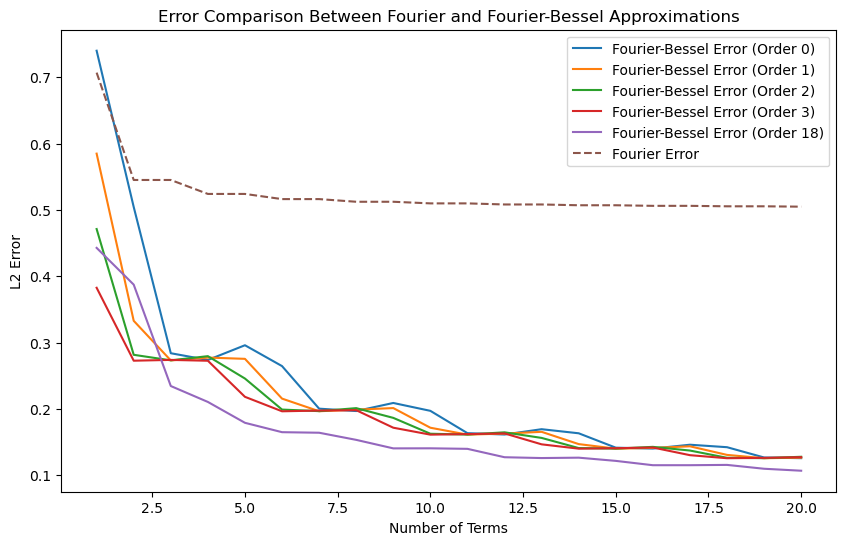

Minimum terms required for each order to reach the target error for gaussian_pulse: {0: 16, 1: 15, 2: 15, 3: 14, 18: 11}


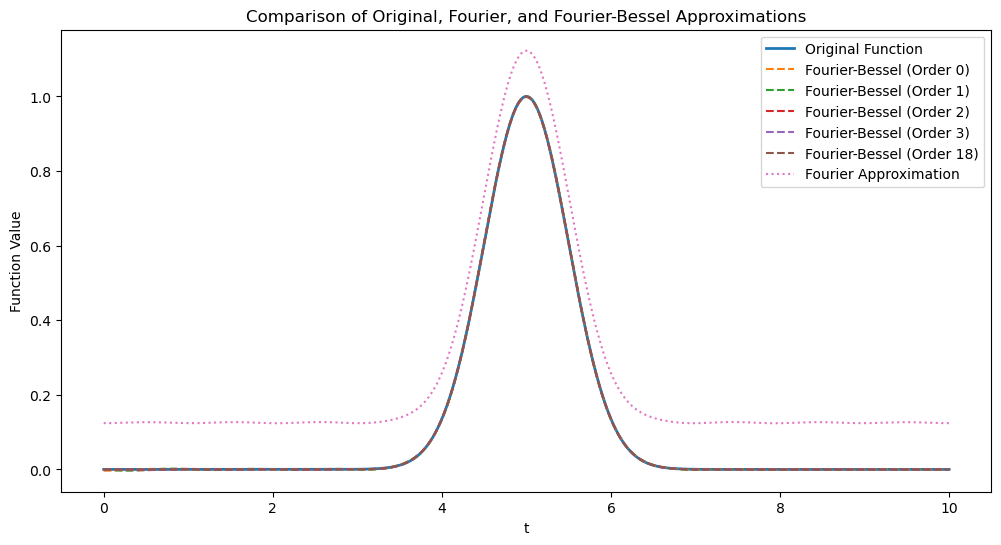

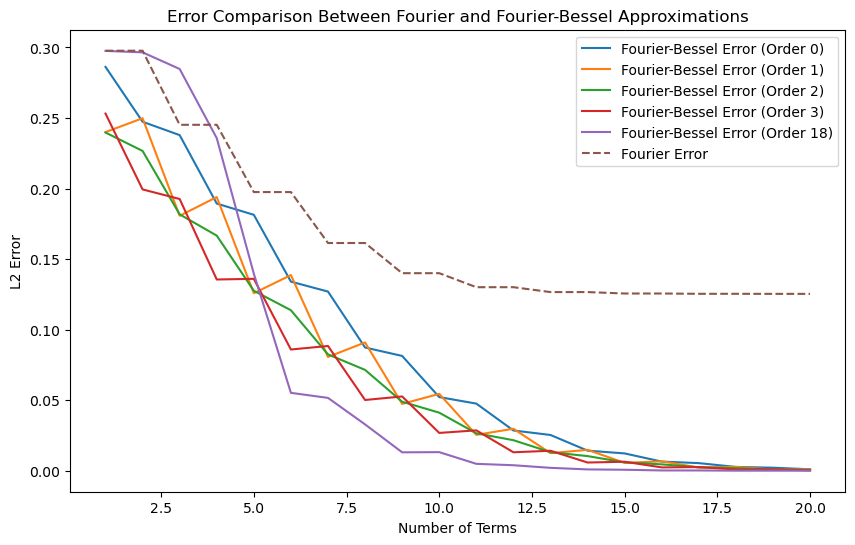

Minimum terms required for each order to reach the target error for sawtooth_wave: {0: 49, 1: 49, 2: 49, 3: 49, 18: 49}


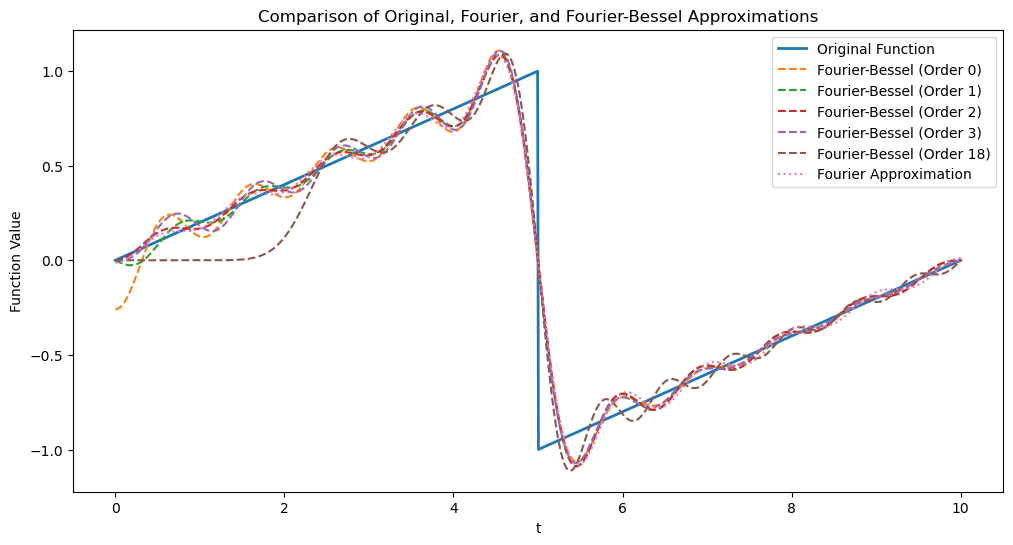

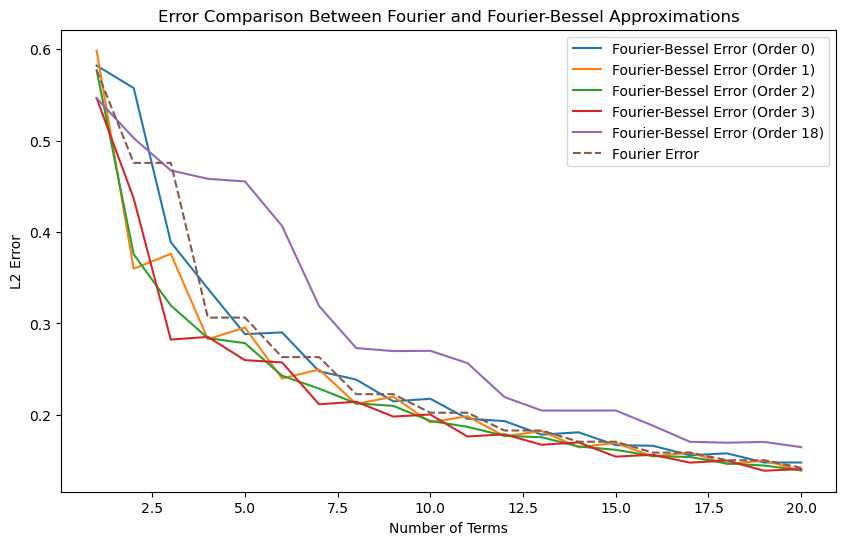

Minimum terms required for each order to reach the target error for single_impulse: {0: 49, 1: 49, 2: 49, 3: 49, 18: 49}


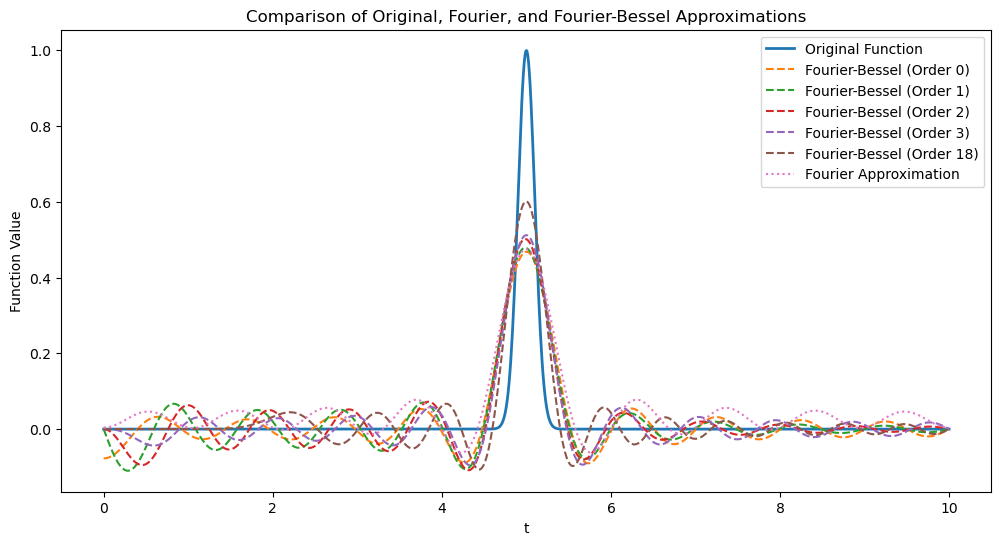

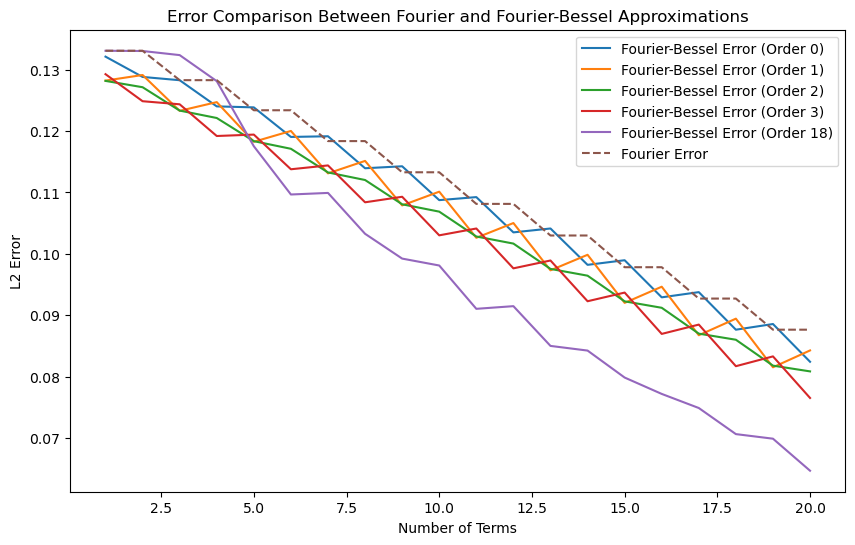

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, jn_zeros

# Define additional target functions for testing
def target_func1(t):
    return np.sin(t)  # Sinusoidal function

def target_func2(t):
    return t**2  # Polynomial function

def target_func3(t):
    return np.exp(-t / 10)  # Exponential decay function

def sawtooth_wave(t, period=10):
    return 2 * (t / period - np.floor(t / period + 0.5))

def gaussian_pulse(t, mean=5, std_dev=0.5):
    return np.exp(-((t - mean) ** 2) / (2 * std_dev ** 2))


def unit_step(t):
    return np.where(t >= 5, 1, 0)  # Step at t=5 for an interval [0, R]

def single_impulse(t, t0=5, height=1, width=0.1):
    """
    Approximates a single impulse (Dirac delta-like spike) at t = t0.
    - t: Array of points over the interval [0, R]
    - t0: Location of the impulse
    - height: Height of the impulse
    - width: Width of the impulse
    """
    return height * np.exp(-((t - t0) ** 2) / (2 * width ** 2))



# Parameters
orders = [0, 1, 2, 3, 18]  # Orders to evaluate
target_error = 0.01  # Define the error threshold
max_terms = 20  # Maximum terms for approximation
R = 10  # Upper bound for the interval

# Fourier-Bessel Series Approximation Function
def fourier_bessel_series_approx(target_func, R, n, num_terms):
    t = np.linspace(0, R, 1000)
    approx = np.zeros_like(t)
    roots = jn_zeros(n, num_terms)  # Get the roots for order n
    for k in range(num_terms):
        root = roots[k]
        J_n_root = jv(n, root * t / R)
        coeff = (2 / (R**2 * jv(n+1, root)**2)) * np.trapz(target_func(t) * J_n_root * t, t)
        approx += coeff * J_n_root
    return approx

# Fourier Approximation Function (assuming target_func can be approximated by Fourier series)
def fourier_approximation(target_func, num_terms):
    t = np.linspace(0, R, 1000)
    approx = np.zeros_like(t)
    for k in range(num_terms):
        coeff = 2 * np.trapz(target_func(t) * np.cos(k * np.pi * t / R), t) / R
        approx += coeff * np.cos(k * np.pi * t / R)
    return approx

# Function to calculate the minimum number of terms to reach the target error
def find_min_terms_for_target_error(target_func, R, orders, target_error):
    results = {}
    t = np.linspace(0, R, 1000)
    original = target_func(t)
    
    for n in orders:
        for num_terms in range(1, 50):
            approx = fourier_bessel_series_approx(target_func, R, n, num_terms)
            error = np.sqrt(np.mean((original - approx) ** 2))
            if error <= target_error:
                results[n] = num_terms
                break
        else:
            results[n] = num_terms  # If target not reached, set max terms tried
    return results

# Plotting Approximation Comparisons
def plot_comparisons(target_func, R, orders, max_terms):
    t = np.linspace(0, R, 1000)
    original = target_func(t)
    
    plt.figure(figsize=(12, 6))
    plt.plot(t, original, label="Original Function", linewidth=2)

    for n in orders:
        fb_approx = fourier_bessel_series_approx(target_func, R, n, max_terms)
        plt.plot(t, fb_approx, label=f"Fourier-Bessel (Order {n})", linestyle='--')
    
    fourier_approx = fourier_approximation(target_func, max_terms)
    plt.plot(t, fourier_approx, label="Fourier Approximation", linestyle=':')
    
    plt.legend()
    plt.xlabel("t")
    plt.ylabel("Function Value")
    plt.title("Comparison of Original, Fourier, and Fourier-Bessel Approximations")
    plt.show()

# Plotting Error Metrics
def plot_error_metrics(target_func, R, orders, max_terms):
    t = np.linspace(0, R, 1000)
    original = target_func(t)

    fb_errors = {n: [] for n in orders}
    fourier_errors = []

    for num_terms in range(1, max_terms + 1):
        fourier_approx = fourier_approximation(target_func, num_terms)
        fourier_error = np.sqrt(np.mean((original - fourier_approx) ** 2))
        fourier_errors.append(fourier_error)

        for n in orders:
            fb_approx = fourier_bessel_series_approx(target_func, R, n, num_terms)
            fb_error = np.sqrt(np.mean((original - fb_approx) ** 2))
            fb_errors[n].append(fb_error)

    plt.figure(figsize=(10, 6))
    for n in orders:
        plt.plot(range(1, max_terms + 1), fb_errors[n], label=f"Fourier-Bessel Error (Order {n})")
    plt.plot(range(1, max_terms + 1), fourier_errors, label="Fourier Error", linestyle='--')
    
    plt.xlabel("Number of Terms")
    plt.ylabel("L2 Error")
    plt.title("Error Comparison Between Fourier and Fourier-Bessel Approximations")
    plt.legend()
    plt.show()

# Testing Multiple Target Functions
target_functions = [
    target_func1,         # Sinusoidal
    target_func2,         # Polynomial
    target_func3,         # Exponential Decay
    unit_step,            # Unit Step Function
    gaussian_pulse,       # Gaussian Pulse
    sawtooth_wave,        # Sawtooth Wave
    single_impulse        # Dirac delta
]


for target_func in target_functions:
    min_terms = find_min_terms_for_target_error(target_func, R, orders, target_error)
    print(f"Minimum terms required for each order to reach the target error for {target_func.__name__}: {min_terms}")
    plot_comparisons(target_func, R, orders, max_terms)
    plot_error_metrics(target_func, R, orders, max_terms)
